In [1]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
import gym

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [13]:
# master class that performs environment interaction and learning
class Master():
    def __init__(self,
                 env,
                 dt,
                 stepSize=1):
        
        # gym
        self.env = env
        if type(env.action_space) == gym.spaces.discrete.Discrete:
            self.action_dim = env.action_space.n
            self.discrete_actions = True
        else:
            self.action_dim = env.action_space.shape[0]
            self.discrete_actions = False
            
        self.state_dim = env.observation_space.shape[0]
        self.stepsize = stepSize
        self.dt = dt
        self.state = env.reset()
        self.reward = 0
        self.done = False
        self.reward_history = []
        self.totalReward = 0
        self.current_action = 0
        self.output = np.zeros(self.action_dim)
        
    def step(self,t,x):
        if int(t / self.dt) % self.stepsize != 0:
            return
        
        if self.discrete_actions:
#             action = np.random.choice(self.action_dim, p=softmax(x))
            self.current_action = np.argmax(x)
        else:
            self.current_action = x
#         self.env.render()
#         print(f'STEP... x: {x}, action: {action}')
        self.state, self.reward, self.done, _ = self.env.step(self.current_action)
        self.totalReward += self.reward
        if self.done:
#             print('done')
            self.reward = -2
            self.totalReward += self.reward
            self.reward_history.append(self.totalReward)
            self.state = self.env.reset()
            self.totalReward = 0

    def calculate_Q(self,t,x):

        if int(t*1000) % self.stepsize == 1:
            qmax = x[np.argmax(x)]
            self.output = x
            self.output[self.current_action] = 0.9*qmax + self.reward
            
        return self.output

dt = 1e-3
n_actor = 100
n_place = 100
place_radius = 10
actor_radius = 2
stepSize = 5
actor_lr = 0.05

tau = 0.01

fast_tau = 0
slow_tau = 0.01

env = gym.make('CartPole-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Acrobot-v1')
master = Master(
    env=env,
    dt=dt,
    stepSize=stepSize
)
model = nengo.Network()

with model:
    state_node = nengo.Node(output=master.state)
    reward_node = nengo.Node(output=master.reward)
    place = nengo.Ensemble(n_neurons=1000,
                           dimensions=master.state_dim,
                           radius=place_radius)
    nengo.Connection(state_node, place)
    
    
    actor = nengo.Ensemble(n_neurons=1000,
                           dimensions=master.action_dim,
                           radius=actor_radius)
    actor_learn_conn = nengo.Connection(place,
                                        actor,
                                        function=lambda x:[0]*master.action_dim,
                                        learning_rule_type=nengo.PES(1e-3, pre_synapse=slow_tau),synapse=tau)
    
    step_node = nengo.Node(output=master.step, size_in=master.action_dim)
    nengo.Connection(actor, step_node)
    
    
    q_node = nengo.Node(master.calculate_Q,size_in=2,size_out=2)
    
    nengo.Connection(actor, q_node, synapse=tau)
    
    
    nengo.Connection(q_node,actor_learn_conn.learning_rule,transform =-1,synapse=fast_tau) ##0.9*Q(s',a')+r
    
    nengo.Connection(actor,actor_learn_conn.learning_rule,transform =1,synapse=slow_tau)#Q(s,a)
    
    actor_probe = nengo.Probe(actor, synapse=None)
    place_probe = nengo.Probe(place, synapse=None)
    q_probe = nengo.Probe(q_node, synapse=None)

    
with nengo.Simulator(model) as sim:
    sim.run(10)

master.env.close()

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

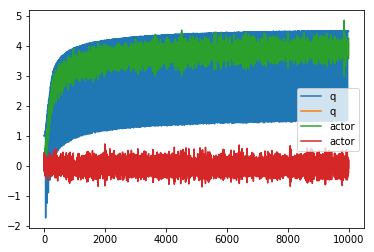

In [14]:
plt.plot(sim.data[q_probe], label='q')
plt.plot(sim.data[actor_probe], label='actor')
# plt.plot(sim.data[critic_probe], label='critic')
# plt.plot(sim.data[place_probe], label='place')
plt.legend()

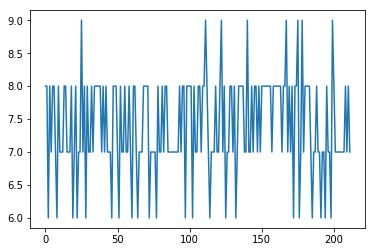

In [15]:
plt.plot(master.reward_history)

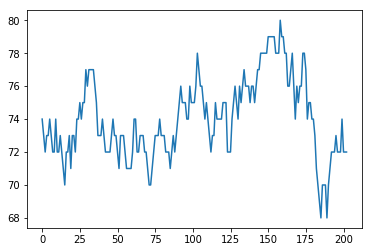

In [16]:
plt.plot(np.convolve(master.reward_history, np.ones(10), 'valid'))